# System Utilization Report

Static text can just be put into Markdown cells


In [150]:
# Let's use shell tools to generate a time stamp 
!echo "Generated on $(date)"

Generated on Tue Oct 17 20:10:56 UTC 2017


In [99]:
# patch the python path, so we can import simple_circ
import sys
sys.path.append("./lib")

# Initialize Circonus Data Fetcher as always
import simple_circ
token = "1193d5ff-7f51-46ca-a6e0-a7f9afd5791b"
api = simple_circ.api(token)

Data fetching with simple_circ generates some debugging output, which I can't disable here.
Patch simple_circ to get rid of this.

In [213]:
# Fetch some data from Circonus

# genereate the timestamp from the beginning of this day:
from datetime import datetime
now = datetime.now()
today = datetime(now.year, now.month, now.day, 0, 0).timestamp()

# fetch the relevant metrics metrics
df_mem = api.search_fetch_tsdf("(check_id:235871) (metric:vm`meminfo`*)", today, 60, 60*24)
df_cpu_idle = api.search_fetch_tsdf("(check_id:235871) (metric:cpu`idle)", today, 60, 60*24)
df_bytes_out = api.search_fetch_tsdf("(check_id:235871) (metric:if`*`out_bytes)", today, 60, 60*24)

fetching {'name': 'vm`meminfo`MemTotal', 'check_id': '235871'}
fetching {'name': 'vm`meminfo`Buffers', 'check_id': '235871'}
fetching {'name': 'vm`meminfo`Cached', 'check_id': '235871'}
fetching {'name': 'vm`meminfo`MemFree', 'check_id': '235871'}
fetching {'name': 'cpu`idle', 'check_id': '235871'}
fetching {'name': 'if`eth0`out_bytes', 'check_id': '235871'}
fetching {'name': 'if`vethf86d566`out_bytes', 'check_id': '235871'}
fetching {'name': 'if`docker0`out_bytes', 'check_id': '235871'}


### CPU Report

In [214]:
# CPU Hours Calculation

cpu_idle=(df_cpu_idle.diff()/60)            # calculate the cpu utilization from the raw metric data
cpu_busy = 100 - cpu_idle                   # busy when not ilde
cpu_busy_ratio = cpu_busy.mean()/100         # mean utilization over the day
cpu_hours_used = float(24 * cpu_busy_ratio)  # cpu hours = 24h * cpu_busy_ratio

In [215]:
# output as text
print("CPU Hours used:  {:.2f} / 24".format(cpu_hours_used))

CPU Hours used:  0.26 / 24


In [216]:
# We can generate markdown cell output as follow:
from IPython.display import Markdown, display
display(Markdown("* CPU hours used {:.2f} / 24".format(cpu_hours_used)))

* CPU hours used 0.26 / 24

### Network Report

In [217]:
# Total Network usage calculation:

# df_bytes_out.diff() -> throughput in bytes each minute
# df_bytes_out.diff().sum() -> total throughput (ignoring nan values)

out = []
out.append("| Interface | Total Throughput in Mb |")
out.append("| --- | --- |")

for k,v in df_bytes_out.diff().sum().items():
    out.append("| {} | {:.1f} | ".format(k,v/1000000))

display(Markdown("\n".join(out)))

| Interface | Total Throughput in Mb |
| --- | --- |
| 235871/if`docker0`out_bytes | 93.4 | 
| 235871/if`eth0`out_bytes | 284.5 | 
| 235871/if`vethf86d566`out_bytes | nan | 

### Memory Report

In [218]:
mem_used = df_mem['235871/vm`meminfo`MemTotal'] - df_mem['235871/vm`meminfo`MemFree']

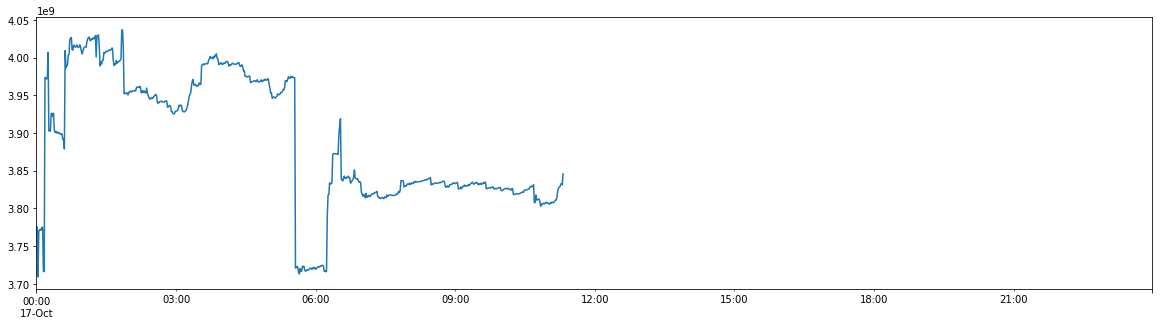

In [219]:
# append a semi-colon to suppress output
mem_used.plot(figsize=(20,5));

# How to generate a report from here?

1. Use the "Hide All Input" nb-extension to hide all input cells in the notebook
2. Hit save
3. Generate a report from the command line with:

```
jupyter-nbconvert --execute --template=nbextensions --to html ExampleReport.ipynb
```

PS: No you can not run this from a cell inside the report ; )